In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, networkx as nx, sklearn.neighbors
!date

Wed Jan  1 19:57:58 PST 2025


# Use refactored code for making eye vessels

In [80]:
dfa = pd.read_csv("123456.csv.bz2",
                index_col=0)
dfb = pd.read_csv("123457.csv.bz2",
                index_col=0)

dfa.loc[:8, 'parent_id'] = 0
dfb.loc[:8, 'parent_id'] = 0

In [81]:
def make_graph(df: pd.DataFrame) -> nx.Graph:
    """
    Generate a NetworkX graph consisting of edges between
    df.index[i] and df.frozen[i].

    Parameters:
        df (pandas.DataFrame): The input DataFrame containing the nodes.

    Returns:
        networkx.Graph: A graph object with edges between the nodes.
        
    Note:
        this function requires the indices of df to be unique
    """
    assert df.index.nunique() == len(df), 'index values of df must be unique'
    graph = nx.DiGraph()
    for v1 in df.index:
        v2 = df.parent_id[v1]
        graph.add_edge(v1, v2)
    
    return graph
make_graph(dfa)

In [82]:
# Create a sample DataFrame
dft = pd.DataFrame({'parent_id': ['A', 'B', 'C', 'D']}, index=['1', '2', '3', '4'])
dft['x'], dft['y'], dft['z'] = 0,0,0
# Call the make_graph function
graph = make_graph(dft)

# Print the graph nodes and edges
print("Nodes:", graph.nodes())
print("Edges:", graph.edges())


Nodes: ['1', 'A', '2', 'B', '3', 'C', '4', 'D']
Edges: [('1', 'A'), ('2', 'B'), ('3', 'C'), ('4', 'D')]


In [83]:
# Test 1: Empty DataFrame
df_empty = pd.DataFrame(columns=['parent_id', 'x', 'y', 'z'])
graph_empty = make_graph(df_empty)
assert len(graph_empty.nodes()) == 0
assert len(graph_empty.edges()) == 0

# Test 2: Single-row DataFrame
df_single_row = pd.DataFrame({'parent_id': ['A']}, index=['1'],)
graph_single_row = make_graph(df_single_row)
assert len(graph_single_row.nodes()) == 2
assert len(graph_single_row.edges()) == 1
assert ('1', 'A') in graph_single_row.edges()

# # Test 3: DataFrame with duplicate index values
# # don't allow this case (added an assert )
# df_duplicate_index = pd.DataFrame({'frozen': ['A', 'B', 'C']}, index=['1', '1', '1'])
# graph_duplicate_index = make_graph(df_duplicate_index)
# assert len(graph_duplicate_index.nodes()) == 4
# assert len(graph_duplicate_index.edges()) == 3
# assert ('1', 'A') in graph_duplicate_index.edges()
# assert ('1', 'B') in graph_duplicate_index.edges()
# assert ('1', 'C') in graph_duplicate_index.edges()

# Test 4: DataFrame with complex index values
df_complex_index = pd.DataFrame({'parent_id': ['A', 'B', 'C']}, index=[('1', 'a'), ('2', 'b'), ('3', 'c')])
graph_complex_index = make_graph(df_complex_index)
assert len(graph_complex_index.nodes()) == 6
assert len(graph_complex_index.edges()) == 3
assert (('1', 'a'), 'A') in graph_complex_index.edges()
assert (('2', 'b'), 'B') in graph_complex_index.edges()
assert (('3', 'c'), 'C') in graph_complex_index.edges()

print("All tests passed!")


All tests passed!


In [84]:
Ga = make_graph(dfa)
# Gb = make_graph(dfb)

In [85]:
def find_leaf_nodes(graph: nx.Graph) -> list:
    """
    Find the leaf nodes (nodes with degree 1) in the given graph.

    Parameters:
        graph (nx.Graph): The input graph.

    Returns:
        list: A list of leaf nodes in the graph.
        
    """
    if len(graph.nodes()) == 1:  # special case
        return graph
    
    leaf_nodes = [node for node in graph.nodes() if graph.degree[node] == 1]
    return leaf_nodes
find_leaf_nodes(Ga);

In [86]:
# Test 1: Empty graph
graph_empty = nx.Graph()
leaf_nodes_empty = find_leaf_nodes(graph_empty)
assert len(leaf_nodes_empty) == 0

# Test 2: Single leaf node  # caught an edge case!
graph_single_leaf = nx.Graph()
graph_single_leaf.add_node('A')
leaf_nodes_single = find_leaf_nodes(graph_single_leaf)
assert len(leaf_nodes_single) == 1
assert 'A' in leaf_nodes_single

# Test 3: Graph with multiple leaf nodes
graph_multiple_leaves = nx.Graph()
graph_multiple_leaves.add_edge('A', 'B')
graph_multiple_leaves.add_edge('B', 'C')
graph_multiple_leaves.add_edge('D', 'E')
graph_multiple_leaves.add_edge('E', 'F')
graph_multiple_leaves.add_edge('F', 'G')
leaf_nodes_multiple = find_leaf_nodes(graph_multiple_leaves)
assert len(leaf_nodes_multiple) == 4
assert 'A' in leaf_nodes_multiple
assert 'C' in leaf_nodes_multiple
assert 'D' in leaf_nodes_multiple
assert 'G' in leaf_nodes_multiple

print("All tests passed!")


All tests passed!


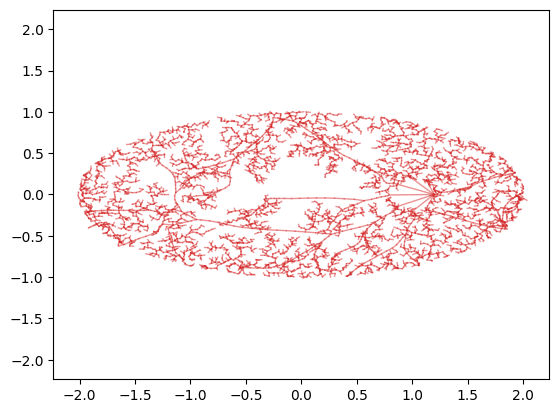

In [87]:
# let's see what it looks like

def my_plot(pop, color):
    for i in pop[~pop.frozen.isnull()].index:
        j = pop.loc[i, 'parent_id']
        if j < 0:
            continue
        xx = [pop.x[i], pop.x[j]]
        yy = [pop.y[i], pop.y[j]]
        plt.plot(xx, yy, '-', alpha=.5, linewidth=1, color=color)


    bnds = plt.axis()
    max_bnd = np.max(bnds)
    plt.axis(xmin=-max_bnd, xmax=max_bnd, ymin=-max_bnd, ymax=max_bnd)
my_plot(dfa, 'C3')

CPU times: user 4.58 s, sys: 83.7 ms, total: 4.67 s
Wall time: 5.26 s


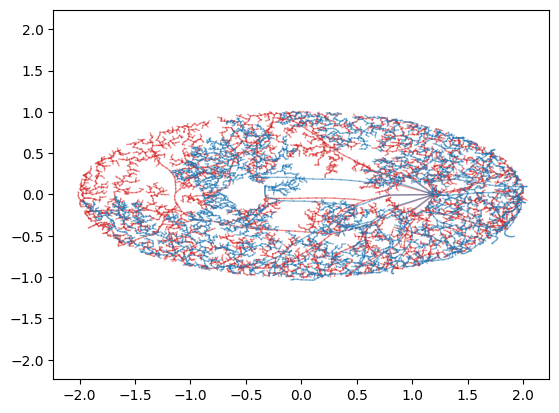

In [88]:
%%time

my_plot(dfa, 'C3')
my_plot(dfb, 'C0')

In [89]:
# TODO: filter out nodes that are not between root of A and B


# actually it doesn't need to be nearby leaves

# match leaves of A to closest point of B
def match_A_leaves(dfa: pd.DataFrame, dfb: pd.DataFrame) -> nx.Graph:
    """
    Take DataFrames dfa and dfb, convert them to graphs using make_graph,
    and return a digraph that is a has edges between
    leaves of dfa nearest point in dfb.

    Parameters:
        dfa (pandas.DataFrame): The first input DataFrame.
        dfb (pandas.DataFrame): The second input DataFrame.

    Returns:
        networkx.DiGraph: A digraph object representing the matching
        between the leaves of dfa and dfb.
    """
    # Convert DataFrames to graphs
    graph_a = make_graph(dfa)

    # Get the leaf nodes of each graph
    leaves_a = find_leaf_nodes(graph_a)
    nodes_b = np.array(dfb.index, dtype='int')

    # Extract the coordinates (x, y, z) of the leaf nodes in each graph
    coordinates_a = [dfa.loc[node, ['x', 'y', 'z']].tolist() for node in leaves_a]
    coordinates_b = dfb.loc[:, ['x', 'y', 'z']].values

    # Use KDTree to find the closest points between the leaf nodes of A and B
    kdtree = sklearn.neighbors.KDTree(coordinates_b)
    distances, indices = kdtree.query(coordinates_a, k=1)

    # Create a new graph for the matching
    connecting_graph = nx.DiGraph()

    # Add edges between nearby leaves based on the calculated distances
    for i, j in enumerate(indices):
        node_a = int(leaves_a[i])
        node_b = int(nodes_b[j])
        if distances[i] < 10:        # TODO: only include edges within a certain critical radius
            connecting_graph.add_edge(('a',node_a), ('b',node_b))

    return connecting_graph

M = match_A_leaves(dfa, dfb)
list(M.edges())[:10]

/tmp/ipykernel_350353/2947771623.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  node_b = int(nodes_b[j])
/tmp/ipykernel_350353/2947771623.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  node_b = int(nodes_b[j])


[(('a', 27), ('b', 2)),
 (('a', 199), ('b', 1693)),
 (('a', 257), ('b', 1341)),
 (('a', 295), ('b', 3600)),
 (('a', 299), ('b', 1203)),
 (('a', 303), ('b', 1945)),
 (('a', 309), ('b', 1268)),
 (('a', 310), ('b', 4655)),
 (('a', 312), ('b', 3421)),
 (('a', 337), ('b', 4733))]

In [90]:
# add direected edges from dfa and dfb to M and then restrict to vertices reachable from dfa
def pruned_network(dfa, dfb, M):

    G = nx.DiGraph()
    
    for u,v in make_graph(dfa).edges(): 
        G.add_edge(('a', int(v)), ('a', int(u)))

    for u,v in make_graph(dfb).edges():
        G.add_edge(('b', int(u)), ('b', int(v)))
        
    for u, v in M.edges():
        G.add_edge(u,v)

    # now restrict G to only nodes
    # reachable by a directed path from node ('a', 0)
    
    reachable_nodes = nx.descendants(G, ('a', 0))
    return G.subgraph(reachable_nodes)

N = pruned_network(dfa, dfb, M)
# list(N.edges())[-10:]

In [91]:
def my_plot_edges(G, dfa, dfb):
    color_a = 'C3'
    color_b = 'C0'
    color_ab = 'C4'
    
    for (p1,i),(p2,j) in G.edges():
        if i < 0 or j < 0:
            continue
        if p1 == p2 == 'a':
            xx = [dfa.x[i], dfa.x[j]]
            yy = [dfa.y[i], dfa.y[j]]
            color = color_a
        elif p1 == p2 == 'b':
            xx = [dfb.x[i], dfb.x[j]]
            yy = [dfb.y[i], dfb.y[j]]
            color = color_b
        else:
            xx = [dfa.x[i], dfb.x[j]]
            yy = [dfa.y[i], dfb.y[j]]
            color = color_ab
        plt.plot(xx, yy, '-', alpha=.25, linewidth=1, color=color)


CPU times: user 5.66 s, sys: 293 ms, total: 5.95 s
Wall time: 6.25 s


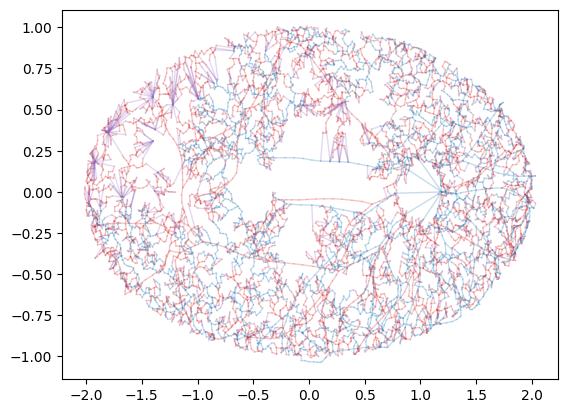

In [92]:
%%time

my_plot_edges(N, dfa, dfb)

In [143]:
def my_interpolate_edges(G, dfa, dfb):
    dots_per_unit = 200
    interpolated_points = []
    
    for (p1,i),(p2,j) in G.edges():
        if i < 0 or j < 0:
            continue
        if p1 == p2 == 'a':
            xx = [dfa.x[i], dfa.x[j]]
            yy = [dfa.y[i], dfa.y[j]]
            zz = [dfa.z[i], dfa.z[j]]
        elif p1 == p2 == 'b':
            xx = [dfb.x[i], dfb.x[j]]
            yy = [dfb.y[i], dfb.y[j]]
            zz = [dfb.z[i], dfb.z[j]]
        else:
            xx = [dfa.x[i], dfb.x[j]]
            yy = [dfa.y[i], dfb.y[j]]
            zz = [dfa.z[i], dfb.z[j]]

        x0,x1 = xx
        y0,y1 = yy
        z0,z1 = zz
        
        edge_length = np.sqrt((x0-x1)**2 + (y0-y1)**2 + (z0-z1)**2)
        n_points = int(np.floor(edge_length * dots_per_unit) + 2)
        alpha = np.linspace(0, 1, n_points)
        
        depth_a = dfa.depth[i]
        if depth_a < 0:
            vessel_radius = .001
        else:
            vessel_radius = .1/max(100, 3**depth_a)
        
        means_to_add = ([x0,y0,z0] + np.outer(alpha, [x1-x0, y1-y0, z1-z0]))
        for _ in range(100):
            points_to_add = np.random.normal(means_to_add, 5*vessel_radius, size=(n_points, 3))
            interpolated_points += points_to_add.tolist()
        
    return np.array(interpolated_points)
        
# my_interpolate_edges(N, dfa, dfb)

In [144]:
%%time

points = my_interpolate_edges(N, dfa, dfb)

CPU times: user 11.6 s, sys: 1.52 s, total: 13.1 s
Wall time: 13 s


In [145]:
# np.random.normal([[0,1]], .1, size=(10,2))

In [146]:
len(points)

8190300

In [147]:
hist, (xedges, yedges, zedges) = np.histogramdd(points, bins=(500, 500, 50))
hist.shape

(500, 500, 50)

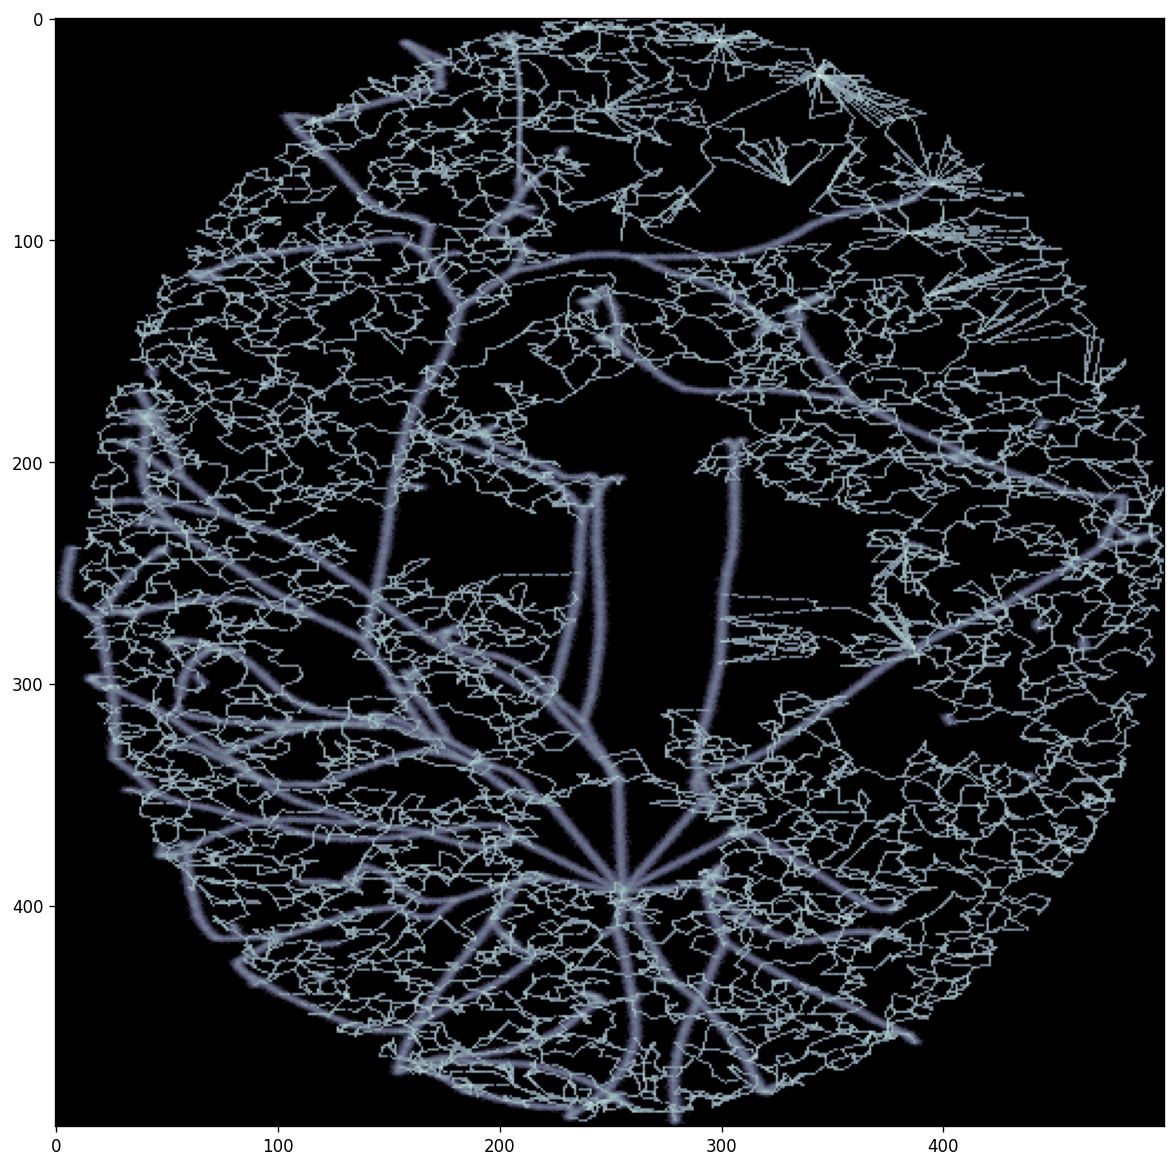

In [150]:
plt.figure(figsize=(12,12), dpi=120)
plt.imshow(np.log(hist.sum(axis=2)+1), cmap='bone')

In [151]:
np.savez_compressed('data.npz', data=hist)
loaded_data = np.load('data.npz')['data']

In [152]:
loaded_data.shape

(500, 500, 50)

In [153]:
!ls -halt data.npz

235490.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


-rw-r--r-- 1 abie abie 621K Jan  4 13:16 data.npz


In [154]:
!cp data.npz /mnt/c/Users/abie/Dropbox/eye_sim/data_2025.npz

235502.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
